## Relevant Code Files and Dataset
https://drive.google.com/drive/folders/1_W77nIU02LBCVpb3NH-_1S3oxYWT-MPu?usp=sharing

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle

In [95]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

train_dir = 'dataSet/Train'
test_dir = 'dataSet/Test'

train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

print("Training Images")
train_data = train_datagen.flow_from_directory(train_dir, target_size = IMAGE_SIZE, batch_size = BATCH_SIZE, class_mode = "categorical", shuffle=True)

print("Testing Images")
test_data = test_datagen.flow_from_directory(test_dir, target_size = IMAGE_SIZE, batch_size = BATCH_SIZE, class_mode = "categorical", shuffle = True)

Training Images
Found 9013 images belonging to 7 classes.
Testing Images
Found 1002 images belonging to 7 classes.


In [96]:
labels = {value: key for key, value in train_data.class_indices.items()}

for key, value in labels.items():
    print(f"{key} : {value}")

0 : akiec
1 : bcc
2 : bkl
3 : df
4 : mel
5 : nv
6 : vasc


In [97]:
lesion_type_dict = {
    5: 'Melanocytic nevi',
    4: 'Melanoma',
    2: 'Benign keratosis-like lesions ',
    1: 'Basal cell carcinoma',
    0: 'Actinic keratoses',
    6: 'Vascular lesions',
    3: 'Dermatofibroma'
}

labels.update(lesion_type_dict)

In [98]:
print(labels)

{0: 'Actinic keratoses', 1: 'Basal cell carcinoma', 2: 'Benign keratosis-like lesions ', 3: 'Dermatofibroma', 4: 'Melanoma', 5: 'Melanocytic nevi', 6: 'Vascular lesions'}


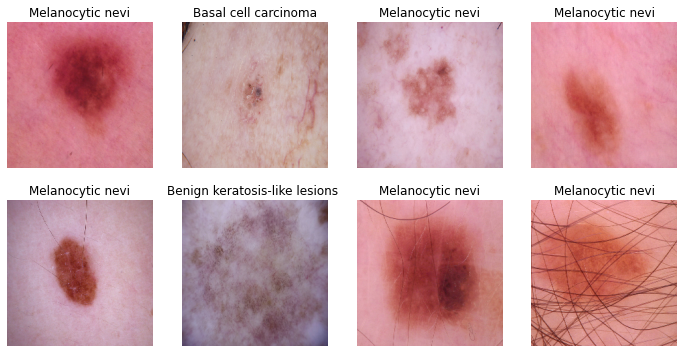

In [99]:
index = 5
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(12, 6))

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_data[0][1][index])]
        ax[i,j].set_title(f"{label}")
        ax[i, j].imshow(train_data[0][0][index][:, :, :])
        ax[i, j].axis("off")
        index += 1

plt.show()

## Avoiding image augmenting due to large dataset size and hardware limitations

In [100]:
_, train_counts = np.unique(train_data.labels, return_counts= True)
_, test_counts = np.unique(test_data.labels, return_counts= True)

In [101]:
print(train_counts)

[ 294  463  989  103 1002 6034  128]


In [102]:
from tensorflow.keras import backend as K

def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())

def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())


def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Modifying a custom CNN into an SVM Classifier

#### Final dense layer to use l2 norm kernel regularizer
#### Using the squared_hinge loss function and softmax activation function (multi-class classification) during compiling

#### These 2 steps allow us to perform image classification using SVM

In [103]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu', input_shape = (224, 224, 3)))
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate = 0.8))
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate = 0.8))
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate = 0.8))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate = 0.8))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate = 0.8))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(rate = 0.5))
    model.add(layers.Dense(7, kernel_regularizer = l2(0.01),activation='softmax'))

    model.compile(optimizer = optimizers.Adam(learning_rate= 0.0010), loss = 'squared_hinge', 
                                                metrics = ['accuracy',sensitivity, precision,recall,specificity])
    
    return model

In [104]:
model = create_model()
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_158 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 conv2d_159 (Conv2D)         (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 110, 110, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_66 (Bat  (None, 110, 110, 32)     128       
 chNormalization)                                                
                                                                 
 dropout_79 (Dropout)        (None, 110, 110, 32)      0         
                                                                 
 conv2d_160 (Conv2D)         (None, 108, 108, 64)    

### Ensuring TensorFlow GPU is working

In [105]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4117468761753718715
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5762973696
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17854465148642971691
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [106]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_learningRate = ReduceLROnPlateau(monitor = 'val_loss', factor = np.sqrt(0.1), patience = 5)

In [107]:
EPOCHS = 30

custom_svm_history = model.fit(train_data,
                    epochs = EPOCHS,
                    validation_data = test_data,
                    callbacks = reduce_learningRate,
                    )

Epoch 1/30
282/282 [==============================] - 70s 244ms/step - loss: 1.1134 - accuracy: 0.6384 - sensitivity: 0.6308 - precision: 0.6390 - recall: 0.6308 - specificity: 0.9442 - val_loss: 1.0601 - val_accuracy: 0.6697 - val_sensitivity: 0.6725 - val_precision: 0.6725 - val_recall: 0.6725 - val_specificity: 0.9454 - lr: 0.0010
Epoch 2/30
282/282 [==============================] - 39s 137ms/step - loss: 1.0488 - accuracy: 0.6699 - sensitivity: 0.6587 - precision: 0.6847 - recall: 0.6587 - specificity: 0.9491 - val_loss: 1.1991 - val_accuracy: 0.1098 - val_sensitivity: 0.1117 - val_precision: 0.1240 - val_recall: 0.1117 - val_specificity: 0.8676 - lr: 0.0010
Epoch 3/30
282/282 [==============================] - 38s 134ms/step - loss: 1.0366 - accuracy: 0.6766 - sensitivity: 0.6526 - precision: 0.7088 - recall: 0.6526 - specificity: 0.9551 - val_loss: 1.1898 - val_accuracy: 0.2605 - val_sensitivity: 0.2055 - val_precision: 0.3013 - val_recall: 0.2055 - val_specificity: 0.9201 - lr:

In [108]:
tf.keras.models.save_model(model, 'custom_svm_model.h5')

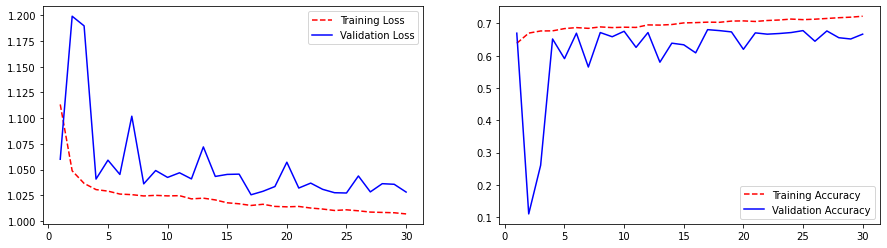

In [109]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = custom_svm_history.history['loss']
validation_loss = custom_svm_history.history['val_loss']

training_accuracy = custom_svm_history.history['accuracy']
validation_accuracy = custom_svm_history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

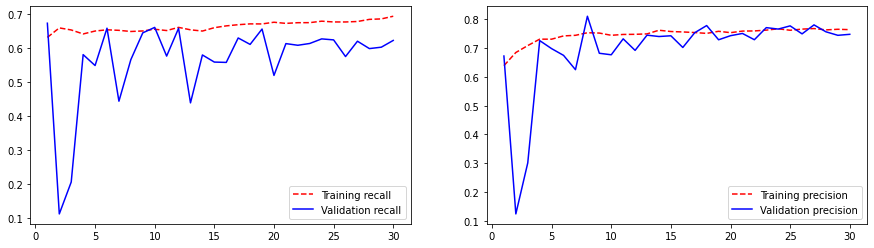

In [110]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_recall = custom_svm_history.history['recall']
validation_recall = custom_svm_history.history['val_recall']
training_precision = custom_svm_history.history['precision']
validation_precision =custom_svm_history.history['val_precision']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_recall, 'r--')
axs[0].plot(epoch_count, validation_recall, 'b-')
axs[0].legend(['Training recall', 'Validation recall'])

axs[1].plot(epoch_count, training_precision, 'r--')
axs[1].plot(epoch_count, validation_precision, 'b-')
axs[1].legend(['Training precision', 'Validation precision'])


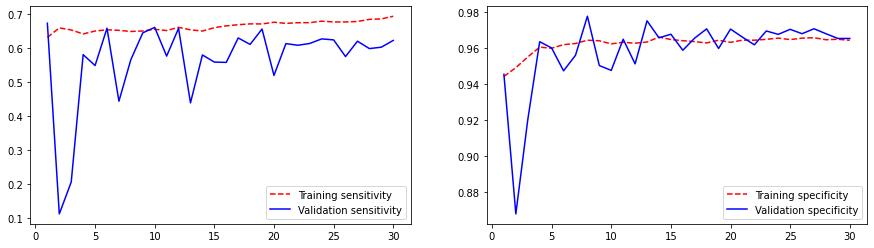

In [111]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_mean_iou =custom_svm_history.history['sensitivity']
validation_mean_iou = custom_svm_history.history['val_sensitivity']

training_specificity = custom_svm_history.history['specificity']
validation_specificity = custom_svm_history.history['val_specificity']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_mean_iou, 'r--')
axs[0].plot(epoch_count, validation_mean_iou, 'b-')
axs[0].legend(['Training sensitivity', 'Validation sensitivity'])

axs[1].plot(epoch_count, training_specificity, 'r--')
axs[1].plot(epoch_count, validation_specificity, 'b-')
axs[1].legend(['Training specificity', 'Validation specificity'])